In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import h5py
import glob
from IPython.display import HTML
from tqdm import tqdm
import math
from scipy.optimize import curve_fit

In [2]:
n_particles = 6
basepath = f"/u/jerbo/arepo/run/scaling_sims/sim_n{n_particles}_particles/output/"

In [3]:
def get_data_from_file(basepath, i, param):
    path = glob.glob(basepath+f"snap_*{i}.hdf5")[0]
    with h5py.File(path, "r") as f:
        cds = f[f'PartType1/{param}'][:]
    
    return cds

# param = "Coordinates"
# coordinates = get_data_from_file(basepath, 0, param)
# print(coordinates[:10])

In [4]:
def simple_hist_plot(basepath, snapnum, parameter, resolution, mask_zeros=True):
    
    mask_zeros_value = 0.7 # set zero bins to this value, so that the log colorbar works
    
    # get the data
    coordinates = get_data_from_file(basepath, snapnum, parameter)
    
    # calculate the density for each bin
    dm_particle_mass = 0  # will have units of 10^10 M_sun/h
    box_size = 0  # will have units of ckpc/h
    with h5py.File(basepath+"snap_000.hdf5", "r") as f:
        header = f['Header']
        dm_particle_mass = header.attrs['MassTable'][1]
        box_size = header.attrs['BoxSize']
    physical_bin_volume = (box_size/resolution)**2 * box_size  # this is a projection, so one axis has the full length of the box
    unit_density_of_bin = dm_particle_mass/physical_bin_volume*1e10  # M_sun/ckpc
    
    
    # calculate the hist
    h, xedges, yedges = np.histogram2d(coordinates[:, 0], coordinates[:, 1], bins=resolution)
    
    if mask_zeros:
        h[h == 0] = mask_zeros_value
        norm = mpl.colors.LogNorm(vmin=h.min(), vmax=h.max())
    else:
        norm = mpl.colors.LogNorm(vmax=h.max())

    # plot
    fig, ax = plt.subplots(dpi=150)
    img = ax.imshow(h.T, origin='lower', cmap='viridis',
                    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                    norm=norm, interpolation='nearest')

    cbar = plt.colorbar(img, ax=ax)
    
    # make colorbar nice
    ticks = cbar.get_ticks()
    new_labels = [f"{tick * unit_density_of_bin:.1e}" for tick in ticks]
    cbar.set_ticks(ticks)
    cbar.set_ticklabels(new_labels)
    cbar.set_label(r"Density [$M_\odot$/ckpc]")
    
    ax.set_xlabel('x [ckpc/h]')
    ax.set_ylabel('y [ckpc/h]')
    ax.set_title('2D Projection Histrogramm')
    plt.show()

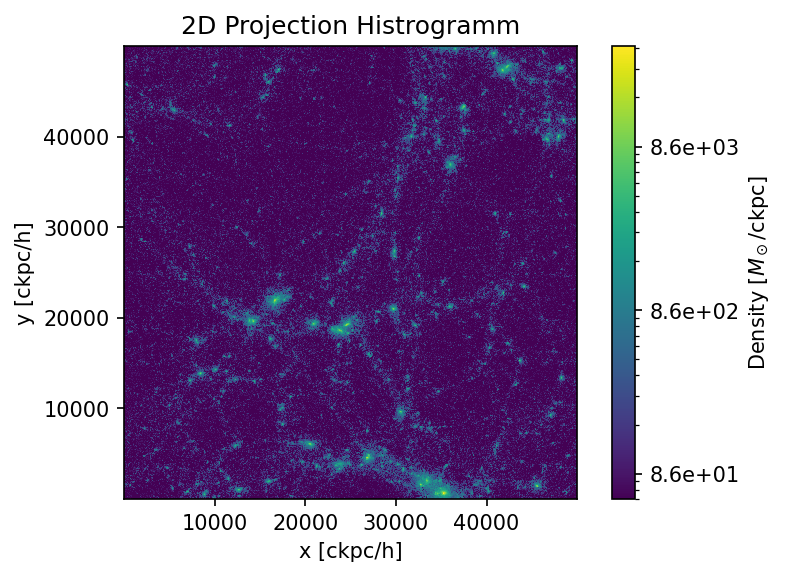

In [5]:
simple_hist_plot(basepath, 2, 'Coordinates', 512)

## Matter power spectrum

In [6]:
densities = get_data_from_file(basepath, 0, "SubfindDMDensity")
coordinates = get_data_from_file(basepath, 0, "Coordinates")*1e-3

resolution = 128

with h5py.File(basepath+"snap_000.hdf5", "r") as f:
    header = f['Header']
    
    box_size = header.attrs['BoxSize']*1e-3 # in kpc/h
    
grid_cell_length = box_size/resolution

print(f"Resoution: {resolution} cells per dimension")
print(f"Total Simulation box size: {box_size} Mpc")
print(f"Length of grid cell: {grid_cell_length} Mpc")

Resoution: 128 cells per dimension
Total Simulation box size: 50.0 Mpc
Length of grid cell: 0.390625 Mpc


In [7]:
coordinates.shape

(262144, 3)

In [8]:
densities.shape

(262144,)

In [9]:
# create uniform grid
x, y, z = [np.linspace(0, box_size, resolution) for i in range(3)]
print(x.shape, y.shape, z.shape)
x_grid, y_grid, z_grid = np.meshgrid(x, y, z, indexing="ij")
print(x_grid.shape, y_grid.shape, z_grid.shape)


(128,) (128,) (128,)
(128, 128, 128) (128, 128, 128) (128, 128, 128)


In [10]:
random_point = [3, 20, 40]
rho = np.zeros((resolution,resolution,resolution), dtype=np.float32)
print(rho.shape)

for i in range(0, resolution-1):
    for j in range(0, resolution-1):
        for k in range(0, resolution-1):  
            sum_rho = 0
            count = 0
            if 0 < x_grid[i+1][j][k] - random_point[0] <= grid_cell_length \
                and 0 < y_grid[i][j+1][k] - random_point[1] <= grid_cell_length \
                and 0 < z_grid[i][j][k+1] - random_point[2] <= grid_cell_length:
                print(f"point in grid cell x={x_grid[i][j][k]}-{x_grid[i+1][j][k]}," \
                      f"y={y_grid[i][j][k]}-{y_grid[i][j+1][k]}," \
                      f"z={z_grid[i][j][k]}-{z_grid[i][j][k+1]}")
                sum_rho += 5
                count += 1
            
            if count == 0:
                rho[i][j][k] = 0
            else:
                print(f"Putting value at {i},{j},{k}")
                rho[i][j][k] = sum_rho/count
                

(128, 128, 128)
point in grid cell x=2.7559055118110236-3.1496062992125986,y=19.68503937007874-20.078740157480315,z=39.76377952755906-40.15748031496063
Putting value at 7,50,101


## Halo mass function

In [5]:
grid_point = 1
basepath = f"/u/jerbo/arepo/run/grid_search_dm_only/grid_point_{grid_point}/output/"

In [6]:
def print_structure(name, obj):
    print(name)

In [7]:
def get_data_from_fof_file(basepath, i, param1, param2):
    path = glob.glob(basepath+f"fof_subhalo_tab_*{i}.hdf5")[0]
    with h5py.File(path, "r") as f:
        # f.visititems(print_structure)
        cds = f[f'{param1}/{param2}'][:]
    
    return cds
    
subhalo_masses = get_data_from_fof_file(basepath, 5, 'Subhalo', 'SubhaloMass')
halo_masses = get_data_from_fof_file(basepath, 5, 'Group', 'GroupMass')

In [8]:
print(np.sum(halo_masses), np.sum(subhalo_masses))

1811685.9 1749432.0


In [9]:
# Difference of a few percent!! -> Due to particles inside halos that are not bound
# to any subhalo?? 

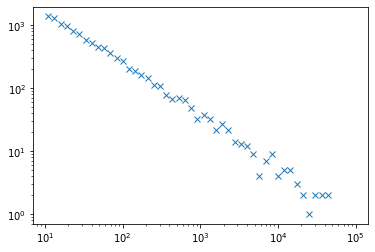

In [13]:
n_bins = 50

log_binning = True

############# Create log bins #############

min_subhalo_mass = np.log10(subhalo_masses.min())
max_subhalo_mass = round(np.log10(subhalo_masses.max()))

if min_subhalo_mass <= 1:
    min_subhalo_mass = 1
else:
    min_subhalo_mass = round(min_subhalo_mass)   
    
log_bins = np.logspace(min_subhalo_mass, max_subhalo_mass, n_bins+1)

#############                 #############

if log_binning:
    bins = log_bins
else:
    bins = n_bins
    
############ Create Histrogram #############

hist, edges = np.histogram(subhalo_masses, bins=bins)
x_values = np.array([(edges[i+1]-edges[i])/2+edges[i] for i in range(len(hist))])

plt.plot(x_values, hist, linestyle="None", marker="x")
plt.yscale("log")
plt.xscale("log")
# plt.xlim([0, 5000])

In [18]:
# TODO: understand how $\alpha$ depends on the cosmology (analytic models such as Press-Schechter)
#       maybe I can even make a prediction based on my cosmological parameters and check!

# TODO: clean this code and make it a function that I can automatically throw at tons of simulations


Calculating best minimal value for power law fit
With powerlaw Package:  1.8163513381180998 0.007742885550653765
With self coded Maximum Likelihood estimation: 1.8163513187196287 0.007742885366664183


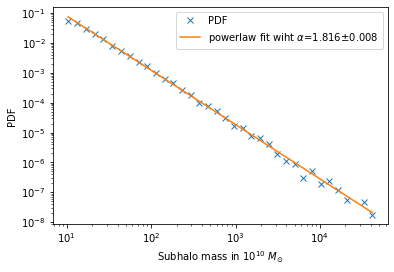

In [26]:
def powerlaw_function(m, m_min, alpha):
    return (alpha-1)/m_min * (m/m_min)**(-alpha)

import powerlaw
fit = powerlaw.Fit(subhalo_masses)

alpha = fit.power_law.alpha
d_alpha = fit.power_law.sigma
m_min = fit.power_law.xmin

print("With powerlaw Package: ", alpha, d_alpha)

def maximum_likelihood_estimate(data, m_min):
    filtered = data[data >= m_min]
    n = len(filtered)
    alpha = 1 + n / np.sum(np.log(filtered / m_min))
    return alpha

def mle_std(alpha_hat, data, m_min):
    n = len(data[data >= m_min])
    return (alpha_hat - 1)/np.sqrt(n)

alpha = maximum_likelihood_estimate(subhalo_masses, m_min)
d_alpha = mle_std(alpha, subhalo_masses, m_min)
print("With self coded Maximum Likelihood estimation:", alpha, d_alpha)

# Fit PDF with explicit binning
x_vals, y_vals = fit.pdf()
bin_widths = np.diff(x_vals)

manual_centers = np.sqrt(x_vals[:-1] * x_vals[1:])  # Geometric mean

plt.plot(manual_centers, y_vals, 'x', label="PDF")
plt.plot(manual_centers, powerlaw_function(manual_centers, m_min, alpha),
         label=r"powerlaw fit wiht $\alpha$="+f"{alpha:.3f}"+r"$\pm$"+f"{d_alpha:.3f}")

plt.yscale("log")
plt.xscale("log")
plt.ylabel(r"PDF")
plt.xlabel(r"Subhalo mass in $10^{10}$ $M_{\odot}$")
plt.legend()
plt.show()

In [27]:
m_min

9.609640121459961